In [65]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import pandas as pd
from nanonets import Simulation
from nanonets.utils import fft, generate_band_limited_noise, get_displacement_currents, get_SET_TAU_F0
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

plt.style.use(["science","bright","grid"])

def get_lattice_electrode_cap_matrix(L: int):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*8}
    sim  = Simulation(topo)
    return sim.get_electrode_capacitance_matrix()

def memory_capacity(x: np.ndarray, u: np.ndarray, lags: np.ndarray) -> tuple[float, np.ndarray]:
    """
    Calculates the Linear Memory Capacity (MC) analytically using covariance matrices.
    
    This measures how much information about the past input u(t-k) is contained 
    linearly within the reservoir state x(t). It is equivalent to the R^2 score 
    of an optimally trained linear readout for each lag.

    Parameters:
    -----------
    x : np.ndarray
        State matrix of shape (steps, N_nodes). 
        Can be Potentials (recommended) or Charges.
    u : np.ndarray
        Input signal of shape (steps,).
    lags : np.ndarray or list
        Integer delays k to evaluate (e.g., np.arange(1, 100)).

    Returns:
    --------
    total_mc : float
        Sum of MC over all provided lags.
    mc_k : np.ndarray
        The specific MC values for each lag.
    """
    
    # 1. Preprocessing: Center the data (Remove Mean)
    # We ignore the intercept term by centering, which simplifies the math.
    X_centered = x - np.mean(x, axis=0)
    u_centered = u - np.mean(u)
    
    T = X_centered.shape[0]
    
    # 2. Compute State Covariance Matrix (Sigma_X)
    # Shape: (N, N)
    Sigma_X = (X_centered.T @ X_centered) / (T - 1)
    
    # 3. Compute Pseudo-Inverse of Sigma_X
    # We use pinv (Pseudo-inverse) because if nodes are highly correlated 
    # (e.g., neighbors in a chain), the matrix is singular/ill-conditioned.
    Sigma_X_inv = np.linalg.pinv(Sigma_X)
    
    # 4. Variance of Input (Normalization factor)
    var_u = np.var(u_centered, ddof=1)
    
    mc_k = []
    
    for k in lags:
        if k == 0:
            # Zero lag is usually not considered "memory", but we can calc it.
            # No shifting needed.
            u_shifted = u_centered
            valid_indices = slice(None)
        else:
            # Shift input back by k steps: u(t-k)
            # We must truncate the arrays to align valid data points.
            # x[k:] corresponds to u[0:-k] (which represents u at t-k)
            u_shifted = u_centered[:-k]
            X_truncated = X_centered[k:]
            
            # Recalculate covariances for the truncated segment to be exact
            # (Or assume stationarity and use full X. Truncation is safer for short series.)
            # Cross-Covariance p_k = Cov(x(t), u(t-k))
            p_k = (X_truncated.T @ u_shifted) / (len(u_shifted) - 1)
            
            # 5. Calculate MC_k
            # Formula: p_k.T @ Sigma_inv @ p_k / var(u)
            # This is mathematically identical to the R^2 of a linear regression.
            score = (p_k.T @ Sigma_X_inv @ p_k) / var_u
            
            # R^2 cannot theoretically exceed 1.0, but numerical noise might cause 1.000001
            score = min(score, 1.0)
            mc_k.append(score)

    mc_k = np.array(mc_k)
    total_mc = np.sum(mc_k)
    
    return total_mc, mc_k

In [47]:
N_PARTICLES     = 9
# FREQ_LIST_MHZ   = [266.,610.,1200.,2400.]
FREQ_LIST_MHZ   = [1.,2.,5.,6.,8.,10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.,2400.]
PATH            = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/Noise/white_noise/"
DT              = 1e-11
C_US            = get_lattice_electrode_cap_matrix(N_PARTICLES).T
BURN_IN_RATIO   = 0.2
TAU_SET, F0_SET = get_SET_TAU_F0()

In [3]:
for freq in tqdm(FREQ_LIST_MHZ):
    try:
        data    = pd.read_csv(f"{PATH}Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne=8_{freq:.3f}.csv")
        x       = data['E0'].values
        y_t     = data['Observable'].values
        y_e     = data['Error'].values
        n_steps = len(y_t)
        n_drop  = int(BURN_IN_RATIO * n_steps)
        x       = x[n_drop:]
        y_e     = y_e[n_drop:]
        y_t     = y_t[n_drop:]
        state   = pd.read_csv(f"{PATH}mean_state_Nx={N_PARTICLES}_Ny={N_PARTICLES}_Ne=8_{freq:.3f}.csv")
        p       = state.iloc[n_drop:,8:].values
        y_d     = get_displacement_currents(p, C_US, DT)
        y       = y_t + y_d

        stride  = int(1.0 / (freq * 1e6 * DT))
        stride  = max(1, stride)
        u_str   = x[::stride]
        y_str   = y[::stride]
        y_e_str = y_e[::stride]

        np.save(f"../data/x_{freq:.3f}.npy", u_str)
        np.save(f"../data/y_{freq:.3f}.npy", y_str)
        np.save(f"../data/y_e_{freq:.3f}.npy", y_e_str)
        print("data saved")
    except:
        print(f"Skipping {freq} MHz (File not found)")
        continue

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [03:38<10:55, 218.66s/it]

data saved


 50%|█████     | 2/4 [07:19<07:19, 219.87s/it]

data saved


 75%|███████▌  | 3/4 [11:09<03:44, 224.34s/it]

data saved


100%|██████████| 4/4 [15:03<00:00, 225.87s/it]

data saved


In [68]:
mc_mean = {}
mc_std = {}
mc_k_mean = {}
mc_k_std = {}
boot = 50
max_lags = 100
for freq in tqdm(FREQ_LIST_MHZ):
    try:
        # Load Data
        x   = np.load(f"../data/x_{freq:.3f}.npy")
        y   = np.load(f"../data/y_{freq:.3f}.npy")
        y_e = np.load(f"../data/y_e_{freq:.3f}.npy")
        lags = np.arange(min(max_lags, len(y) // 2))

        if np.any(np.isnan(y)) or np.any(np.isnan(x)):
            print(f"Skipping {freq}: NaNs found")
            continue
        
        # Prepare containers for this frequency
        mc_boot_list = []
        mc_k_boot_list = []
        
        # Calculate SEM (Standard Error) from your stored 95% CI
        sem = y_e / 1.96
        for _ in range(boot):
            # 1. Perturb y by its statistical error
            noise = np.random.normal(loc=0.0, scale=sem, size=y.shape)
            y_perturbed = y + noise
            
            # 2. Calculate MC
            mc, mc_k = memory_capacity(y_perturbed[:,np.newaxis], x[:,np.newaxis], lags)
            
            # 3. Store results
            mc_boot_list.append(mc)
            mc_k_boot_list.append(mc_k)

        # Convert list of arrays to 2D matrix: (boot, n_lags)
        mc_k_matrix = np.array(mc_k_boot_list)

        # 4. Aggregate Statistics
        mc_mean[freq] = np.mean(mc_boot_list)
        mc_std[freq]  = np.std(mc_boot_list)
        
        # Axis 0 is the bootstrap dimension
        mc_k_mean[freq] = np.mean(mc_k_matrix, axis=0) 
        mc_k_std[freq]  = np.std(mc_k_matrix, axis=0)
        
    except:
        print(f"Skipping {freq} MHz (File not found)")
        continue

 32%|███▏      | 7/22 [00:00<00:00, 66.85it/s]

Skipping 1.0 MHz (File not found)
Skipping 2.0 MHz (File not found)
Skipping 28.0 MHz (File not found)


 86%|████████▋ | 19/22 [00:00<00:00, 39.51it/s]

Skipping 133.0 MHz (File not found)


100%|██████████| 22/22 [00:01<00:00, 17.37it/s]


<Axes: ylabel='Density'>

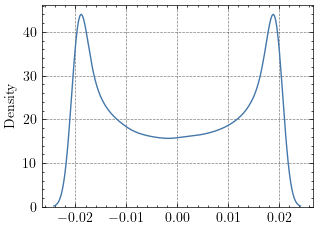

In [82]:
import seaborn as sns
sns.kdeplot(np.sin(np.linspace(0,100,100000))*0.02)

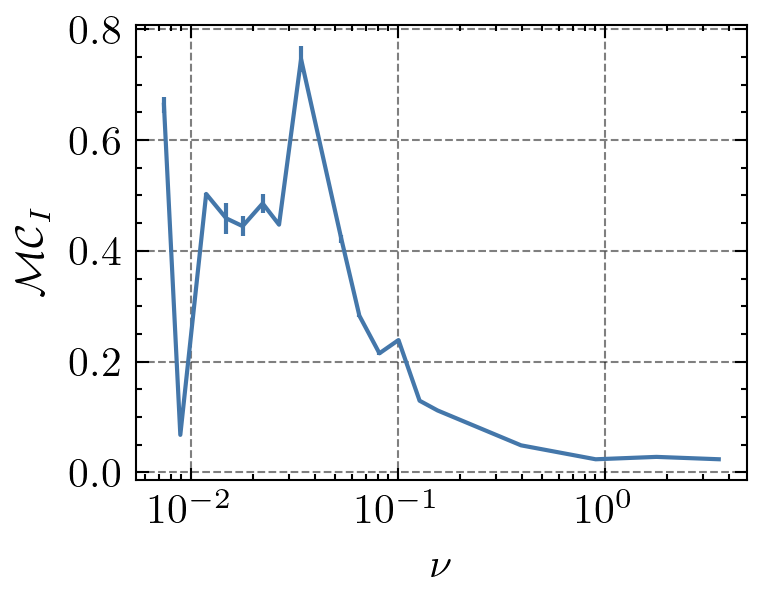

In [67]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

_   = ax.errorbar(x=np.array([key for key in mc_mean.keys()])/F0_SET, y=[val for _, val in mc_mean.items()], yerr=[val for _, val in mc_std.items()])
_   = ax.set_xlabel("$\\nu$")
_   = ax.set_ylabel("$\mathcal{MC}_{I}$")
_   = ax.set_xscale('log')
# _   = ax.set_yscale('log')
# _   = ax.set_xlim(1e-2, 1e1)

In [39]:
mc_mean = {}
mc_std = {}
mc_k_mean = {}
mc_k_std = {}
max_lags = 100
for freq in tqdm(FREQ_LIST_MHZ):
    try:
        # Load Data
        x   = np.load(f"../data/x_{freq:.3f}.npy")
        y   = np.load(f"../data/y_{freq:.3f}.npy")
        y_e = np.load(f"../data/y_e_{freq:.3f}.npy")
        lags = np.arange(min(max_lags, len(y) // 2))
        
        # 2. Calculate MC
        mc, mc_k = memory_capacity(y[:,np.newaxis], x, lags)
        
        mc_mean[freq] = mc
        
        # Axis 0 is the bootstrap dimension
        mc_k_mean[freq] = mc_k 
        
    except:
        print(f"Skipping {freq} MHz (File not found)")
        continue

 27%|██▋       | 6/22 [00:00<00:00, 54.76it/s]

Skipping 1.0 MHz (File not found)
Skipping 2.0 MHz (File not found)
Skipping 28.0 MHz (File not found)
Skipping 133.0 MHz (File not found)


100%|██████████| 22/22 [00:00<00:00, 94.61it/s] 


In [63]:
n_per       = 1000
lags        = np.arange(1, n_per)
mc_s        = {N : memory_capacity(p[N],x[N],lags)[0] for N in [9]}
mc_I        = {N : memory_capacity(y[N][:,np.newaxis],x[N],lags)[0] for N in [9]}
mc_s_vs_lag = {N : memory_capacity(p[N],x[N],lags)[1] for N in [9]}
mc_I_vs_lag = {N : memory_capacity(y[N][:,np.newaxis],x[N],lags)[1] for N in [9]}

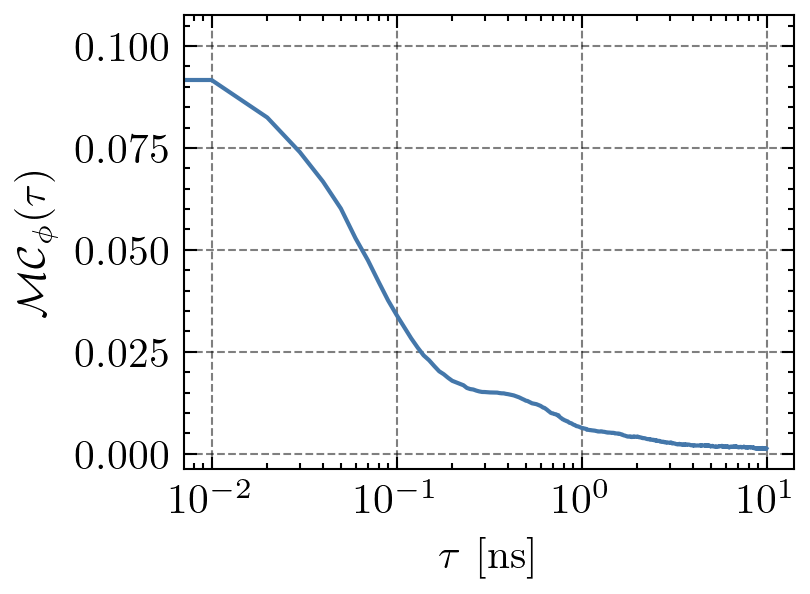

In [64]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

_   = ax.plot(np.arange(n_per-1)*DT*1e9, mc_s_vs_lag[9])
_   = ax.set_xlabel("$\\tau~[\mathrm{ns}]$")
_   = ax.set_ylabel("$\mathcal{MC}_{\phi}(\\tau)$")
_   = ax.set_xscale('log')
# _   = ax.set_yscale('log')
# _   = ax.set_xlim(1e-2, 1e1)

In [ ]:
AMPLITUDE    = 0.01
BANDWIDTH_HZ = 4.35e9
DURATION     = 20e-6
DT           = 1e-11
t, x         = generate_band_limited_noise(DURATION, BANDWIDTH_HZ, DT, is_pink=False)
xf, yf       = fft(x, DT)

NameError: name 't' is not defined

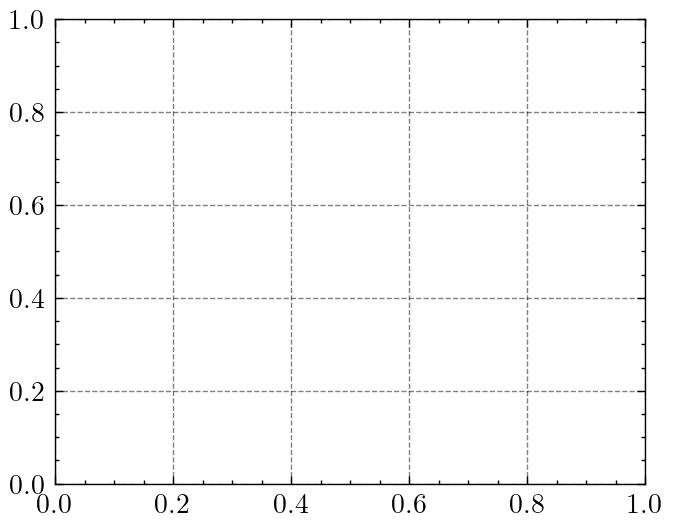

In [65]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
ax  = fig.add_subplot(1,2,1)
ax.plot(t*1e9, x*1000)
ax.set_ylabel("$U$ [mV]")
ax.set_xlabel("$t$ [ns]")
ax  = fig.add_subplot(1,2,2)
ax.plot(xf*1e-6, yf)
ax.set_ylabel("$P$ [a.u.]")
ax.set_xlabel("$f_0$ [MHz]")
ax.set_yscale('log')
ax.set_ylim(1e-4)

In [19]:
1/0.23

4.3478260869565215

In [ ]:
def mutual_information(x: np.ndarray, y: np.ndarray, num_bins: int) -> float:
    """
    Calculates the Mutual Information between two continuous time series.

    The function discretizes the continuous signals into a 2D histogram and then
    computes the Mutual Information I(X; Y) = H(X) + H(Y) - H(X, Y), where H
    is the Shannon entropy.

    Args:
        x (np.ndarray): The first time series (e.g., input voltage).
        y (np.ndarray): The second time series (e.g., output current).
                        Must have the same length as x.
        num_bins (int): The number of bins to use for discretizing each variable.
                        This is a crucial parameter that affects the result.

    Returns:
        float: The Mutual Information between x and y in bits.
    """
    if len(x) != len(y):
        raise ValueError("Input arrays must have the same length.")
    if len(x) == 0:
        return 0.0

    # 1. Create the 2D histogram from the data.
    # This gives us the joint counts of (x, y) pairs.
    joint_hist, _, _ = np.histogram2d(x, y, bins=num_bins)

    # 2. Convert the joint counts to a joint probability distribution.
    joint_prob = joint_hist / np.sum(joint_hist)

    # 3. Calculate the marginal probabilities by summing over rows and columns.
    marginal_prob_x = np.sum(joint_prob, axis=1)
    marginal_prob_y = np.sum(joint_prob, axis=0)

    # 4. Calculate the individual entropies and the joint entropy.
    # We only sum over non-zero probabilities, as log2(0) is undefined.
    
    # Entropy of X: H(X)
    h_x = -np.sum(p * np.log2(p) for p in marginal_prob_x if p > 0)
    
    # Entropy of Y: H(Y)
    h_y = -np.sum(p * np.log2(p) for p in marginal_prob_y if p > 0)
    
    # Joint Entropy of X and Y: H(X, Y)
    h_xy = -np.sum(p * np.log2(p) for p in joint_prob.flatten() if p > 0)

    # 5. Calculate Mutual Information: I(X; Y) = H(X) + H(Y) - H(X, Y)
    mi = h_x + h_y - h_xy
    
    return mi

def mutual_information_corrected(x: np.ndarray, y: np.ndarray, num_bins: int) -> tuple[float, float]:
    """
    Calculates the Mutual Information with Miller-Madow bias correction.
    """
    if len(x) != len(y):
        raise ValueError("Input arrays must have the same length.")
    N = len(x)
    if N == 0:
        return 0.0, 0.0

    joint_hist, _, _ = np.histogram2d(x, y, bins=num_bins)
    joint_prob = joint_hist / N

    marginal_prob_x = np.sum(joint_prob, axis=1)
    marginal_prob_y = np.sum(joint_prob, axis=0)
    
    # --- Naive MI Calculation (as before) ---
    h_x = -np.sum(p * np.log2(p) for p in marginal_prob_x if p > 0)
    h_y = -np.sum(p * np.log2(p) for p in marginal_prob_y if p > 0)
    h_xy = -np.sum(p * np.log2(p) for p in joint_prob.flatten() if p > 0)
    mi_naive = h_x + h_y - h_xy

    # --- Miller-Madow Bias Correction ---
    # Count the number of non-empty bins
    b_xy = np.count_nonzero(joint_hist)
    b_x = np.count_nonzero(np.sum(joint_hist, axis=1))
    b_y = np.count_nonzero(np.sum(joint_hist, axis=0))
    
    bias = (b_xy - b_x - b_y) / (2 * N * np.log(2))
    
    mi_corrected = mi_naive - bias
    
    # Corrected MI cannot be negative
    return max(0, mi_corrected), mi_naive

150000000.0

In [ ]:
NUM_SAMPLES     = 16384 
BANDWIDTH_HZ    = 150e6
t, x            = generate_band_limited_white_noise(NUM_SAMPLES, BANDWIDTH_HZ)

V_fft           = fft(x)
freqs           = fftfreq(len(x), t[1] - t[0])
freqs_shifted   = fftshift(freqs)
psd_shifted     = fftshift(np.abs(V_fft)**2)

Text(0.5, 0, '$f_0$ [MHz]')

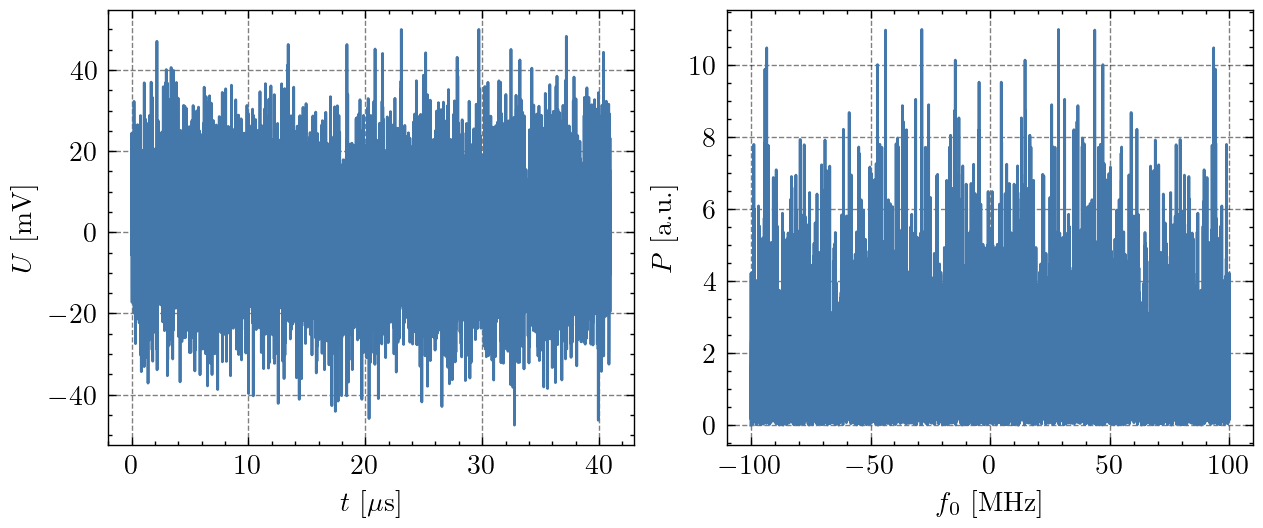

In [165]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
ax  = fig.add_subplot(1,2,1)
ax.plot(t*1e6, x*1000)
ax.set_ylabel("$U$ [mV]")
ax.set_xlabel("$t$ [$\mu$s]")
ax  = fig.add_subplot(1,2,2)
ax.plot(freqs_shifted / 1e6, psd_shifted)
ax.set_ylabel("$P$ [a.u.]")
ax.set_xlabel("$f_0$ [MHz]")

In [236]:
NUM_SAMPLES     = 65536 
BANDWIDTH_HZ    = 100e6
STAT_SIZE       = 1000
N_NP            = 9
N_E             = 8
topo            = {"Nx": N_NP,"Ny": N_NP,
                    "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
                        [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],
                        [N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]
                        ],
                    "electrode_type": ['constant']*N_E}
t_vals, in_vals = generate_band_limited_white_noise(NUM_SAMPLES, BANDWIDTH_HZ, 1.0)
volt            = np.zeros(shape=(NUM_SAMPLES,N_E+1))
volt[:,0]       = in_vals
sim_class       = Simulation(topo, pack_optimizer=False)
sim_class.run_dynamic_voltages(volt, t_vals, N_E-1)

In [237]:
t   = t_vals.copy()[:-1]*1e6
x   = in_vals.copy()[1:]*1e3
y   = sim_class.get_observable_storage()*1e-6
y_e = sim_class.get_observable_error_storage()*1e-6

In [246]:
(t[1]-t[0])*1e-6

5e-09

Text(0, 0.5, '$I$ [pA]')

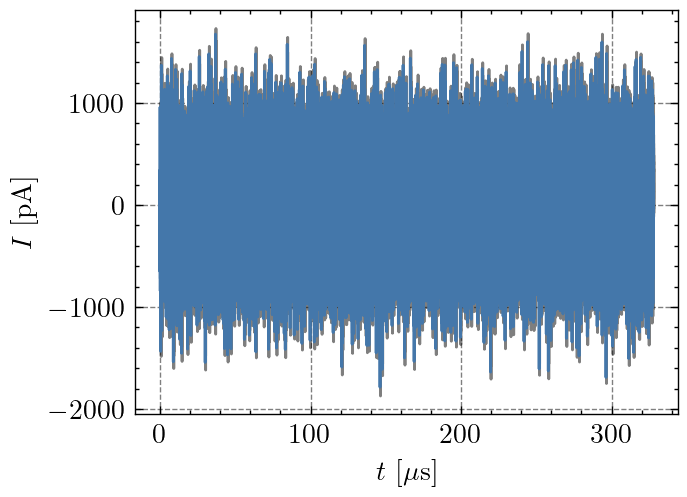

In [243]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t,y)
ax.fill_between(t, y-y_e, y+y_e, color='black', alpha=0.5)
ax.set_xlabel("$t$ [$\mu$s]")
ax.set_ylabel("$I$ [pA]")
# ax.set_xlim(0,1)

Text(0, 0.5, '$I$ [pA]')

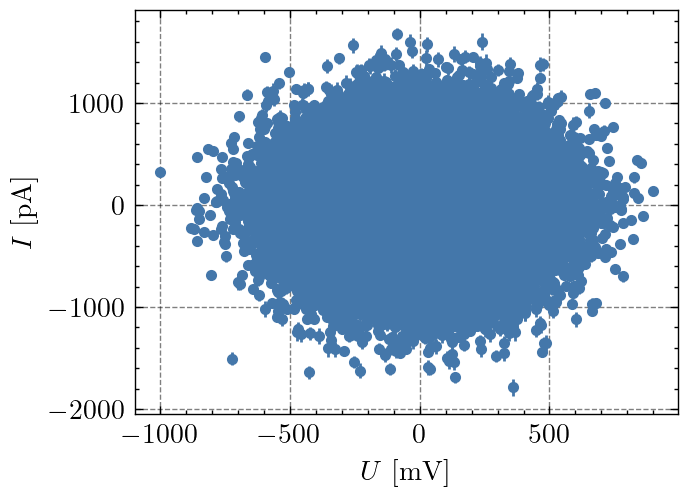

In [239]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.errorbar(x, y, y_e, marker='.', ls='')
ax.set_xlabel("$U$ [mV]")
ax.set_ylabel("$I$ [pA]")

/tmp/ipykernel_1449/1427381408.py:106: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  h_x = -np.sum(p * np.log2(p) for p in marginal_prob_x if p > 0)
/tmp/ipykernel_1449/1427381408.py:107: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  h_y = -np.sum(p * np.log2(p) for p in marginal_prob_y if p > 0)
/tmp/ipykernel_1449/1427381408.py:108: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  h_xy = -np.sum(p * np.log2(p) for p in joint_prob.flatten() if p > 0)


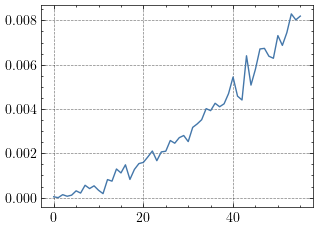

In [240]:
num_bins = np.arange(8,64,1)
mi       = [mutual_information_corrected(x, y, n)[0] for n in num_bins]
plt.plot(mi)

In [241]:
from sklearn.feature_selection import mutual_info_regression

# Note: scikit-learn expects inputs of shape (n_samples, n_features)
# So we need to reshape our 1D arrays.
x_reshaped = x.reshape(-1, 1) # Replace x with your data

# n_neighbors is the key parameter here, similar to num_bins.
# The default is 3, which is a good starting point.
mi_knn = mutual_info_regression(x_reshaped, y, n_neighbors=5)[0]

# The result is in "nats", so we convert to "bits"
mi_knn_bits = mi_knn / np.log(2)
mi_knn_bits

0.0026176995464021013

/tmp/ipykernel_1449/1427381408.py:106: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  h_x = -np.sum(p * np.log2(p) for p in marginal_prob_x if p > 0)
/tmp/ipykernel_1449/1427381408.py:107: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  h_y = -np.sum(p * np.log2(p) for p in marginal_prob_y if p > 0)
/tmp/ipykernel_1449/1427381408.py:108: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  h_xy = -np.sum(p * np.log2(p) for p in joint_prob.flatten() if p > 0)


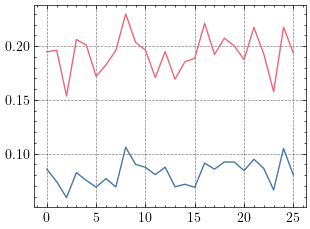

In [242]:
def mutual_info_bits(x, y):
    x_reshaped = x.reshape(-1, 1)
    mi_knn = mutual_info_regression(x_reshaped, y, n_neighbors=5)[0]
    mi_knn_bits = mi_knn / np.log(2)
    return mi_knn_bits

n = 2500
# mi_knn_bits = [mutual_info_bits(x[i*n:(i+1)*n],y[i*n:(i+1)*n]) for i in range(6)]
mi_chunks   = [mutual_information_corrected(x[i*n:(i+1)*n],y[i*n:(i+1)*n], num_bins=32) for i in range(NUM_SAMPLES//n)]
plt.plot(mi_chunks)